In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from glob import glob

from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

In [2]:
print(torch.__version__)
my_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32, device="cpu")
print(my_tensor)
torch.cuda.is_available()

2.2.0.dev20231027+cu121
tensor([[1., 2., 3.],
        [4., 5., 6.]])


True

In [3]:
if torch.cuda.is_available():
    CUDA_DEV = torch.device('cuda')
else:
    CUDA_DEV = torch.device('cpu')
print(CUDA_DEV)
NUM_TAGS = 256

cuda


In [4]:
df_trainval = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_trainval.shape, df_test.shape

((51134, 2), (25580, 1))

In [5]:
df_train, df_val = train_test_split(df_trainval, test_size=0.3)
df_train.shape, df_val.shape

((35793, 2), (15341, 2))

In [6]:
track_idx2embeds = {}
for fn in tqdm(glob('data/track_embeddings/*')):
    track_idx = int(fn.split('\\')[1].split('.')[0])
    embeds = np.load(fn)
    track_idx2embeds[track_idx] = embeds
print(len(track_idx2embeds))

100%|██████████| 76714/76714 [01:51<00:00, 689.64it/s] 


76714


In [49]:
class TaggingDataset(Dataset):
    def __init__(self, df, testing=False):
        self.df = df
        self.testing = testing
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        track_idx = row.track
        embeds = track_idx2embeds[track_idx]
        if self.testing:
            return track_idx, embeds
        tags = [int(x) for x in row.tags.split(',')]
        target = np.zeros(NUM_TAGS)
        target[tags] = 1
        return track_idx, embeds, target


In [50]:
trainval_dataset = TaggingDataset(df_trainval)
train_dataset = TaggingDataset(df_train)
val_dataset = TaggingDataset(df_val)
test_dataset = TaggingDataset(df_test, True)

In [51]:
class Network(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
        )
        self.fc = nn.Linear(hidden_dim, num_classes)
        

    def forward(self, embeds):
        x = [self.projector(x) for x in embeds]
        x = [v.mean(0).unsqueeze(0) for v in x]
        x = self.bn(torch.cat(x, dim = 0))
        x = self.lin(x)
        outs = self.fc(x)
        return outs


In [52]:
val_true = np.array([y[2] for y in val_dataset])
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration,data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()
        
        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 200 == 0:
            _, val_pred = predict(model, val_dataloader)
            val_ap = average_precision_score(val_true, val_pred)
            print('   {} batch {} loss {} val ap {}'.format(
                datetime.now(), iteration + 1, running_loss, val_ap
            ))

In [53]:
def predict(model, loader):
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(CUDA_DEV) for x in embeds]
            pred_logits = model(embeds)
            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions
            

In [54]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [torch.from_numpy(x[1]) for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [torch.from_numpy(x[1]) for x in b]
    return track_idxs, embeds

In [55]:
trainval_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn_test)

In [57]:
model = Network()
criterion = nn.BCEWithLogitsLoss()

epochs = 5
model = model.to(CUDA_DEV)
criterion = criterion.to(CUDA_DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)

for epoch in tqdm(range(epochs)):
    train_epoch(model, train_dataloader, criterion, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

   2023-10-29 19:24:21.317337 batch 1 loss 0.7329624777843295 val ap 0.02405056095295993


 20%|██        | 1/5 [00:41<02:44, 41.05s/it]

   2023-10-29 19:25:02.065434 batch 1 loss 0.8681242999228704 val ap 0.0542846852579698


 40%|████      | 2/5 [01:21<02:02, 40.95s/it]

   2023-10-29 19:25:42.875559 batch 1 loss 0.8636278165423381 val ap 0.08141557585194631


 60%|██████    | 3/5 [02:02<01:21, 40.78s/it]

   2023-10-29 19:26:23.384500 batch 1 loss 0.7339796550536717 val ap 0.09068435247837962


 80%|████████  | 4/5 [02:43<00:40, 40.71s/it]

   2023-10-29 19:27:03.967493 batch 1 loss 0.6893485162137205 val ap 0.0996522478663109


100%|██████████| 5/5 [03:23<00:00, 40.72s/it]


In [29]:
traintest_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_test)
track_idxs_train, train_pred = predict(model, traintest_dataloader)
train_true = np.array([y[2] for y in train_dataset])
average_precision_score(train_true, train_pred)

0.12574123012178615

In [32]:
from torchmetrics.classification import MultilabelAveragePrecision
mlap = MultilabelAveragePrecision(num_labels=256)
torch_train_true = torch.IntTensor(train_true).to(CUDA_DEV)
torch_train_pred = torch.FloatTensor(train_pred).to(CUDA_DEV)
mlap(torch_train_pred, torch_train_true)

tensor(0.1257, device='cuda:0')

In [105]:
track_idxs_train, val_pred = predict(model, val_dataloader)
val_true = np.array([y[2] for y in val_dataset])
track_idxs_train, val_pred = predict(model, val_dataloader)
average_precision_score(val_true, val_pred)

0.2048759572785559

In [107]:
track_idxs, predictions = predict(model, test_dataloader)
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])
predictions_df.to_csv('prediction.csv', index=False)

<Axes: >

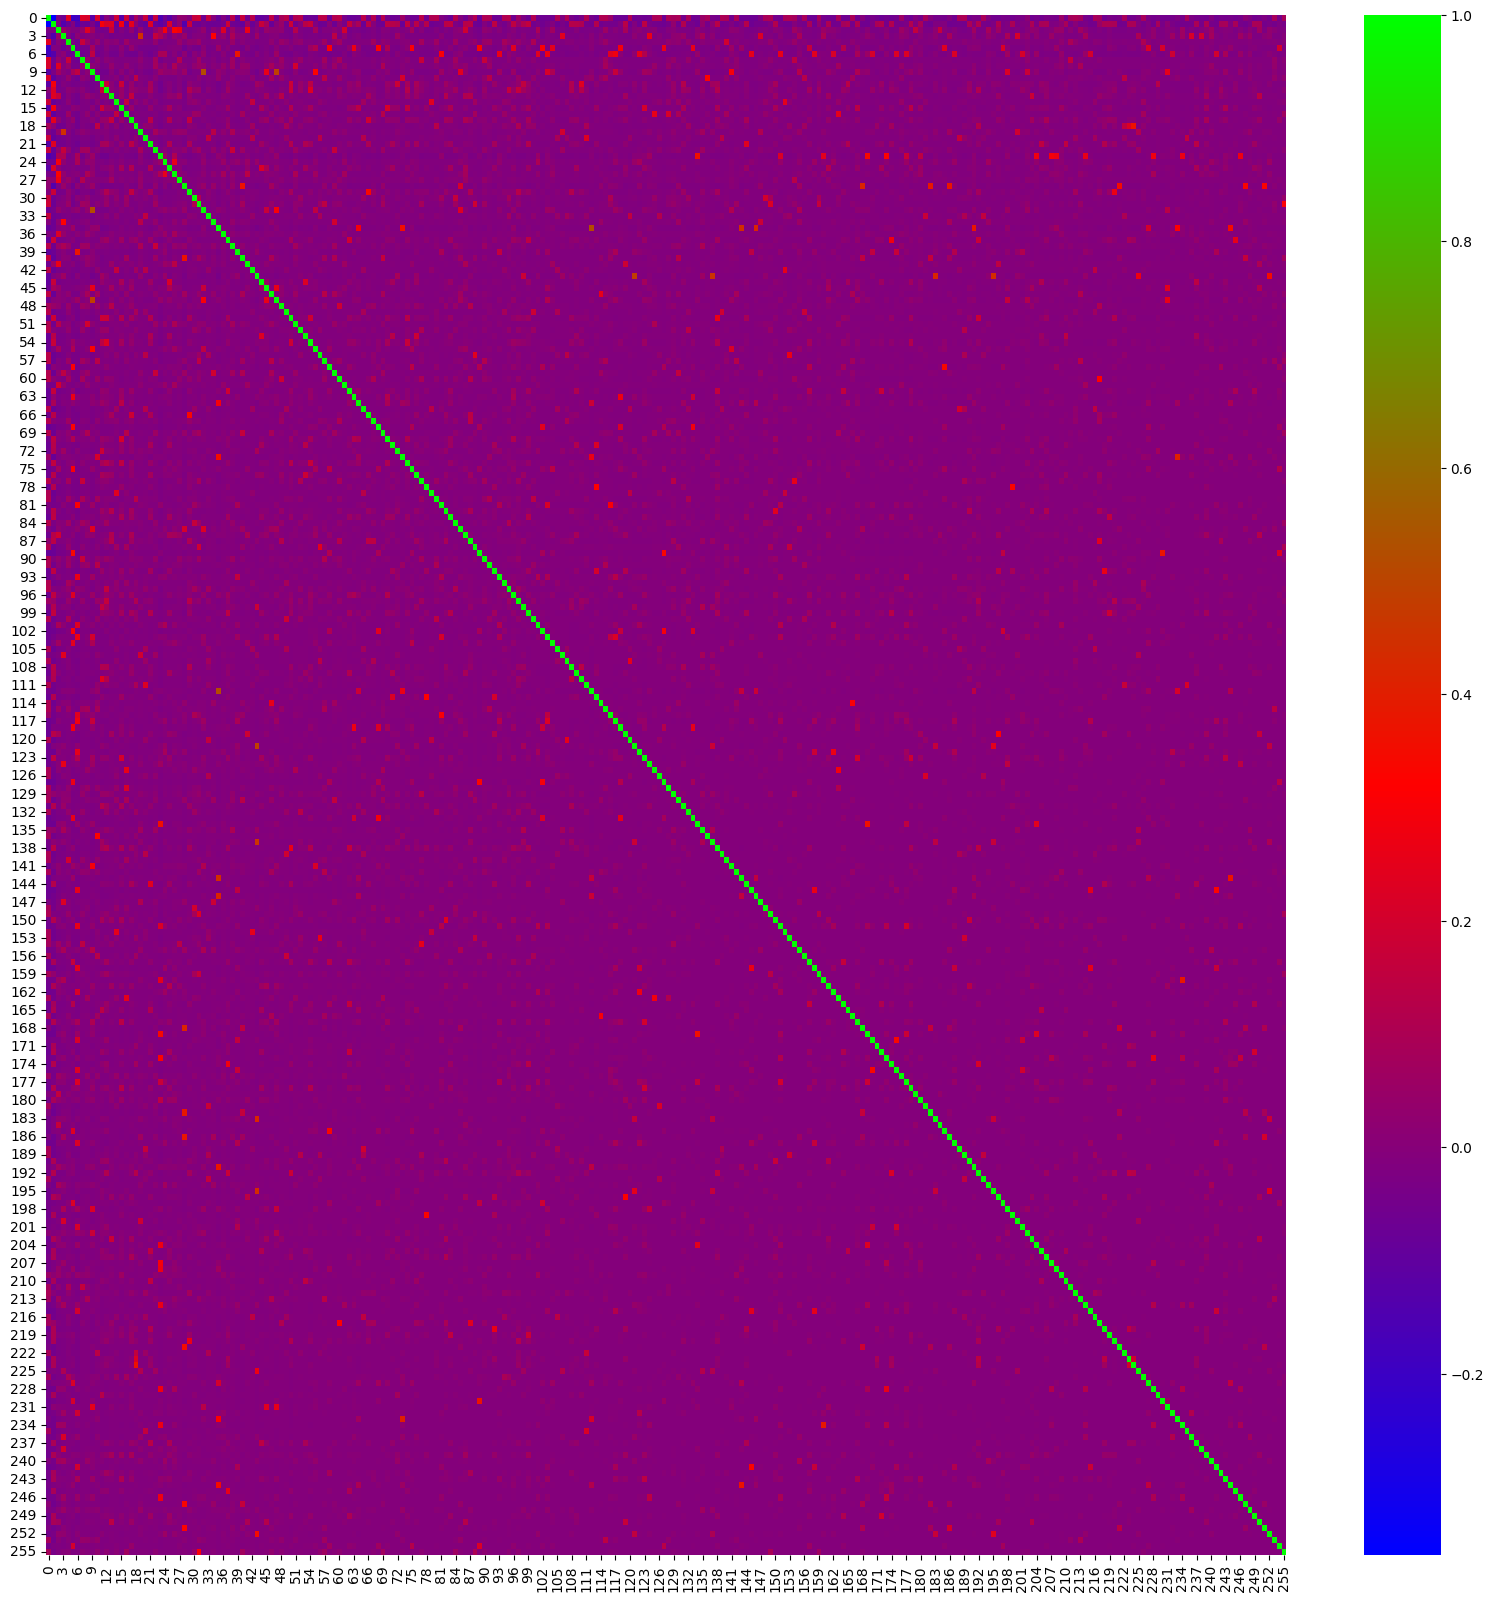

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

train_true = np.array([y[2] for y in train_dataset])
df_tags = pd.DataFrame(train_true)
corr = df_tags.corr()
sb.heatmap(corr, cmap="brg") 

In [19]:
corr

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.000000,-0.359964,-0.034868,-0.072658,0.244664,-0.200692,-0.185697,0.219321,0.211553,-0.119115,...,-0.043362,0.010343,-0.018433,-0.056330,-0.045944,-0.023641,-0.049873,0.081070,-0.045920,0.085698
1,-0.359964,1.000000,-0.024078,-0.138224,-0.073880,-0.013185,-0.131618,-0.064299,-0.073386,-0.034356,...,-0.044335,-0.053454,-0.026064,0.094291,0.087720,-0.049388,-0.034886,-0.047208,-0.020457,-0.040910
2,-0.034868,-0.024078,1.000000,0.049698,0.005087,-0.016201,-0.018714,0.038007,0.227743,0.065337,...,-0.002432,-0.027371,0.008916,-0.020609,0.070213,-0.027703,0.031938,0.003113,-0.018613,-0.018285
3,-0.072658,-0.138224,0.049698,1.000000,-0.023176,-0.072419,0.011956,-0.020722,-0.004055,-0.000198,...,0.064781,0.005399,0.053783,-0.023033,-0.021641,0.008266,0.026357,-0.021777,-0.022513,-0.002854
4,0.244664,-0.073880,0.005087,-0.023176,1.000000,-0.023006,-0.059385,0.168946,0.047726,-0.024233,...,-0.012445,-0.014111,0.000122,-0.014151,-0.013296,-0.011581,-0.008461,-0.000295,-0.011721,0.005449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.023641,-0.049388,-0.027703,0.008266,-0.011581,-0.023277,-0.011936,-0.012413,-0.012504,-0.013818,...,-0.005005,0.052893,-0.004557,-0.004897,-0.004601,1.000000,-0.005018,-0.004630,-0.004786,-0.004744
252,-0.049873,-0.034886,0.031938,0.026357,-0.008461,-0.024623,0.008238,-0.013131,-0.011033,-0.018188,...,-0.005294,-0.005165,0.001031,-0.005180,-0.004867,-0.005018,1.000000,-0.004897,-0.005063,-0.005018
253,0.081070,-0.047208,0.003113,-0.021777,-0.000295,-0.022717,-0.012260,0.042899,0.037685,0.016528,...,-0.004884,-0.004766,-0.004447,-0.004779,-0.004490,-0.004630,-0.004897,1.000000,-0.004671,-0.004630
254,-0.045920,-0.020457,-0.018613,-0.022513,-0.011721,0.200286,-0.025873,-0.012523,-0.012615,-0.014048,...,-0.005049,-0.004926,-0.004598,-0.004940,-0.004642,-0.004786,-0.005063,-0.004671,1.000000,-0.004786


<Axes: >

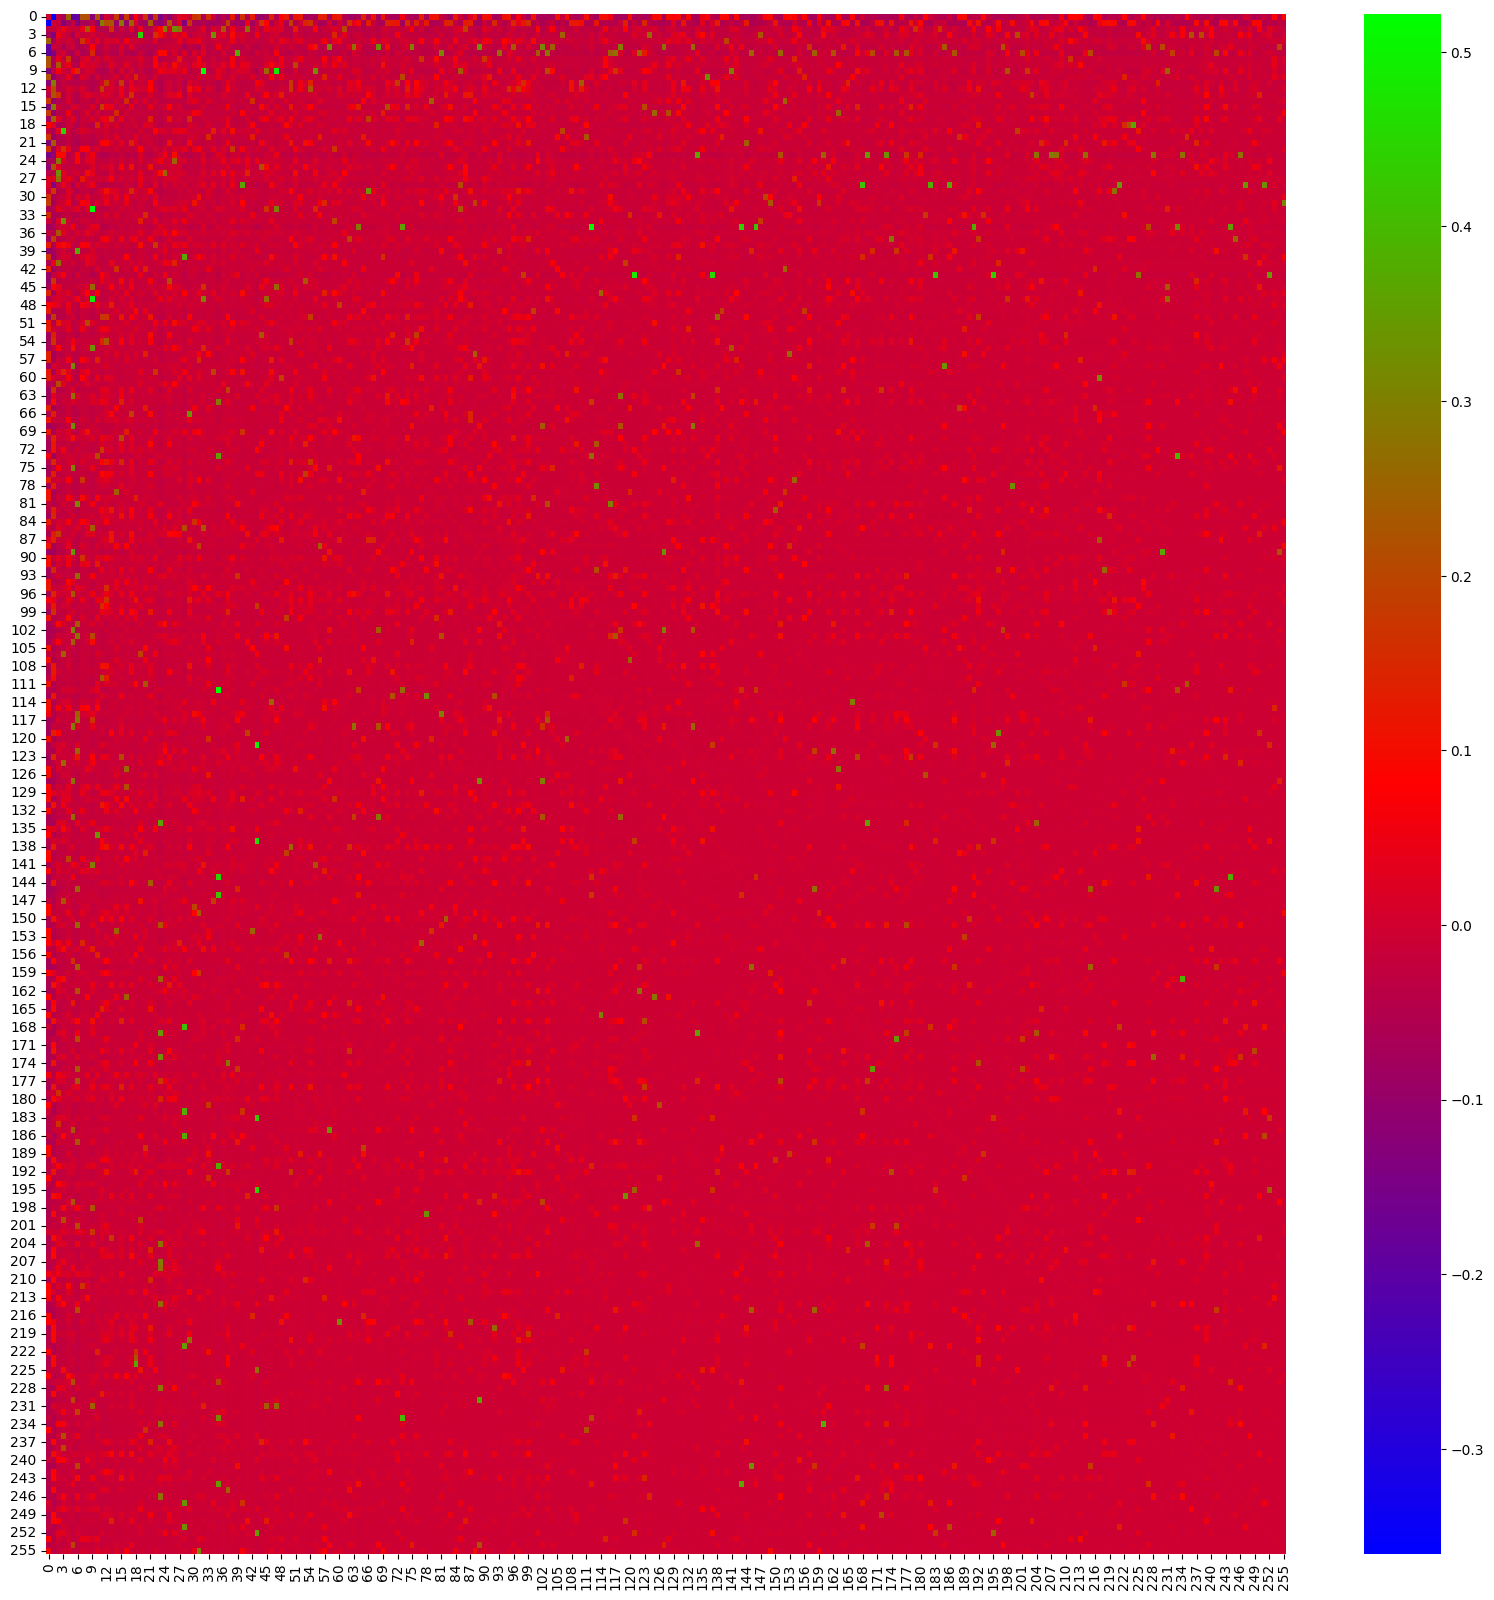

In [18]:
sb.heatmap(corr - np.eye(256), cmap="brg") 